# Machine Learning Story

Here we work with the processed data in the files `df.csv` and `df_type.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from datetime import date, timedelta
from scipy.stats import binom
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.decomposition import PCA

import json
from pandas.io.json import json_normalize

plt.rcParams.update({'errorbar.capsize': 2})

In [2]:
df = pd.read_csv('processed_data/df.csv')

df_type = pd.read_csv('processed_data/df_type.csv')

In [3]:
type_dict = {str(i) : df_type['Type'].tolist()[i] for i in range(df_type.shape[0])}

type_dict

{'0': 'Auto Fire Alarm',
 '1': 'Automatic Fire Alarm Resd',
 '2': 'Automatic Fire Dist 11',
 '3': 'Bark Fire',
 '4': 'Boat Fire In Marina',
 '5': "Boat Under 50' Fire Shore",
 '6': "Boat Under 50' Fire Water",
 '7': 'Brush Fire',
 '8': 'Brush Fire W/Exp.',
 '9': 'Car Fire',
 '10': 'Car Fire Freeway',
 '11': 'Car Fire W/Exp.',
 '12': 'Chimney Fire',
 '13': 'Dumpster Fire',
 '14': 'Dumpster Fire W/Exp.',
 '15': 'Fire Response Freeway',
 '16': 'Fire in Building',
 '17': 'Fire in Single Family Res',
 '18': 'Garage Fire',
 '19': 'Hang-Up, Fire',
 '20': 'Pier Fire',
 '21': 'Rubbish Fire',
 '22': 'Shed Fire',
 '23': "Ship Fire 50'on Shore/Pier",
 '24': 'Train Derailment wFireHzmt',
 '25': 'Tranformer Fire',
 '26': 'Tunnel Fire',
 '27': 'Vault Fire (Electrical)'}

In [4]:
drop_col = df.drop(columns=['Latitude','Longitude','Off_Day']).sum(axis=1).to_frame().apply(lambda row: 1 - row[0], axis=1).values

df['0'] = drop_col.tolist()

print(df.drop(columns=['Latitude','Longitude','Off_Day']).sum(axis=1).unique())

df['Type'] = df.rename(columns=type_dict).drop(columns=['Latitude','Longitude','Off_Day']).idxmax(axis=1)

[1]


In [5]:
df.head()

,Latitude,Longitude,Off_Day,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,0,Type
0,47.608434,-122.338125,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Auto Fire Alarm
1,47.655047,-122.381130,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Car Fire
2,47.621113,-122.358044,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Auto Fire Alarm
3,47.607266,-122.332451,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Auto Fire Alarm
4,47.602114,-122.330809,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Auto Fire Alarm


In [6]:
df2 = df.drop(columns=[str(i) for i in range(df_type.shape[0])])

df2['Off_Day'] = df2['Off_Day'].astype('bool')

df2.head()

,Latitude,Longitude,Off_Day,Type
0,47.608434,-122.338125,False,Auto Fire Alarm
1,47.655047,-122.381130,True,Car Fire
2,47.621113,-122.358044,True,Auto Fire Alarm
3,47.607266,-122.332451,True,Auto Fire Alarm
4,47.602114,-122.330809,False,Auto Fire Alarm


Adding cluster labels:

In [7]:
pca_2D_complete_data_chosen_k_labels = np.load('processed_data/2D_pca_complete_data_chosen_k_labels.npy')
pca_3D_complete_data_chosen_k_labels = np.load('processed_data/3D_pca_complete_data_chosen_k_labels.npy')
complete_data_chosen_k_labels = np.load('processed_data/complete_data_chosen_k_labels.npy')
location_data_chosen_k_labels = np.load('processed_data/location_data_chosen_k_labels.npy')

In [8]:
df2['pca_2D'] = pca_2D_complete_data_chosen_k_labels.tolist()
df2['pca_3D'] = pca_3D_complete_data_chosen_k_labels.tolist()
df2['k_complete'] = complete_data_chosen_k_labels.tolist()
df2['k_location'] = location_data_chosen_k_labels.tolist()

In [9]:
df2.head()

,Latitude,Longitude,Off_Day,Type,pca_2D,pca_3D,k_complete,k_location
0,47.608434,-122.338125,False,Auto Fire Alarm,0,0,1,3
1,47.655047,-122.381130,True,Car Fire,1,5,5,1
2,47.621113,-122.358044,True,Auto Fire Alarm,1,1,0,3
3,47.607266,-122.332451,True,Auto Fire Alarm,1,1,0,3
4,47.602114,-122.330809,False,Auto Fire Alarm,0,0,1,3


In [10]:
df2_small_types = df2[((df2['Type']!='Auto Fire Alarm')&(df2['Type']!='Automatic Fire Alarm Resd'))]
df2_big_types = df2[((df2['Type']=='Auto Fire Alarm')|(df2['Type']=='Automatic Fire Alarm Resd'))]

## 2D PCA Clustering

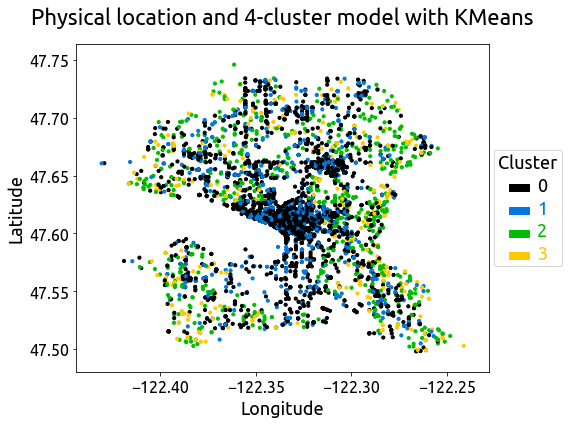

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

n_colors = len(df2['pca_2D'].unique())

colors = cm.nipy_spectral(df2['pca_2D'].values.astype(float) / n_colors)

colors_0 = cm.nipy_spectral(np.linspace(0, n_colors-1, num=n_colors).astype(float) / n_colors)
handles_0 = [mpatches.Patch(color=colors_0[i], label=str(i)) for i in range(n_colors)] 

ax.scatter(df2['Longitude'],df2['Latitude'],c=colors,alpha=1, s=10)

legend = plt.legend(handles=handles_0, title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))
for i in range(n_colors):
    plt.setp(ax.get_legend().get_texts()[i], fontsize='18', fontname='Ubuntu', color = colors_0[i])
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')


ax.set_title("Physical location and "+str(n_colors)+"-cluster model with KMeans", fontsize=22, fontname='Ubuntu', pad= 20)
ax.set_xlabel("Longitude", fontsize=18, fontname='Ubuntu')
ax.set_ylabel("Latitude", fontsize=18, fontname='Ubuntu')
ax.tick_params(labelsize=16)
ax.grid(False)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

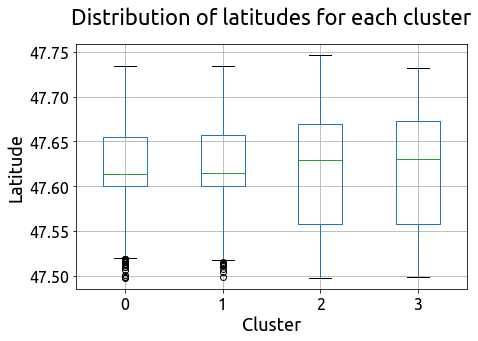

In [12]:
ax = df2.pivot(columns='pca_2D', values='Latitude').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Latitude', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Distribution of latitudes for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4.5)
plt.show()

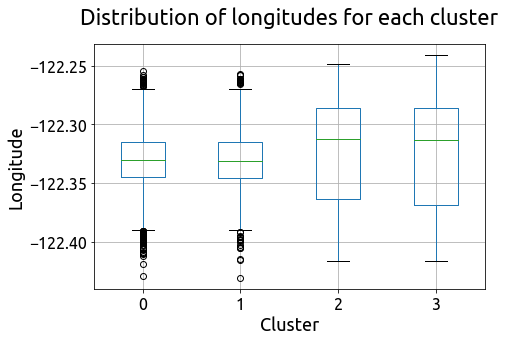

In [13]:
ax = df2.pivot(columns='pca_2D', values='Longitude').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Longitude', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Distribution of longitudes for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4.5)
plt.show()

In [14]:
pd.crosstab(df2.pca_2D, df2.Off_Day)

Off_Day,False,True
pca_2D,,
0,2651,0
1,0,1232
2,616,0
3,0,308


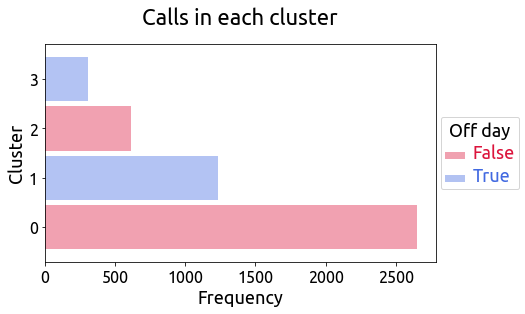

In [15]:
ax = pd.crosstab(df2.pca_2D, df2.Off_Day).plot.barh(stacked=True,color=['crimson','royalblue'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['False','True'], title="Off day", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Calls in each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4)
plt.show()

In [16]:
pd.crosstab(df2_small_types.Type,df2_small_types.pca_2D)

pca_2D,0,1
Type,,
Automatic Fire Dist 11,1,0
Bark Fire,41,20
Boat Fire In Marina,1,0
Boat Under 50' Fire Shore,1,3
Boat Under 50' Fire Water,0,1
Brush Fire,43,19
Brush Fire W/Exp.,2,0
Car Fire,140,52
Car Fire Freeway,44,18


In [17]:
print(pd.crosstab(df2_big_types.Type,df2_big_types.pca_2D))
print('')
print('')
print(pd.crosstab(df2_small_types.Type,df2_small_types.pca_2D))

pca_2D                        0    1    2    3
Type                                          
Auto Fire Alarm            2090  972    0    0
Automatic Fire Alarm Resd     0    0  616  308


pca_2D                        0   1
Type                               
Automatic Fire Dist 11        1   0
Bark Fire                    41  20
Boat Fire In Marina           1   0
Boat Under 50' Fire Shore     1   3
Boat Under 50' Fire Water     0   1
Brush Fire                   43  19
Brush Fire W/Exp.             2   0
Car Fire                    140  52
Car Fire Freeway             44  18
Car Fire W/Exp.               3   2
Chimney Fire                  9   9
Dumpster Fire                23  13
Dumpster Fire W/Exp.          1   1
Fire Response Freeway         5   3
Fire in Building            102  45
Fire in Single Family Res    62  34
Garage Fire                  10   2
Hang-Up, Fire                 3   4
Pier Fire                     1   0
Rubbish Fire                 53  31
Shed Fire         

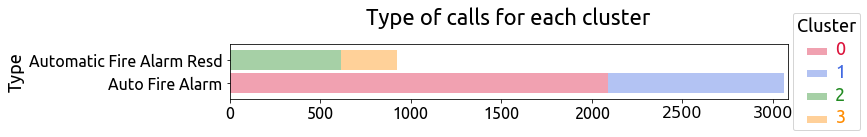

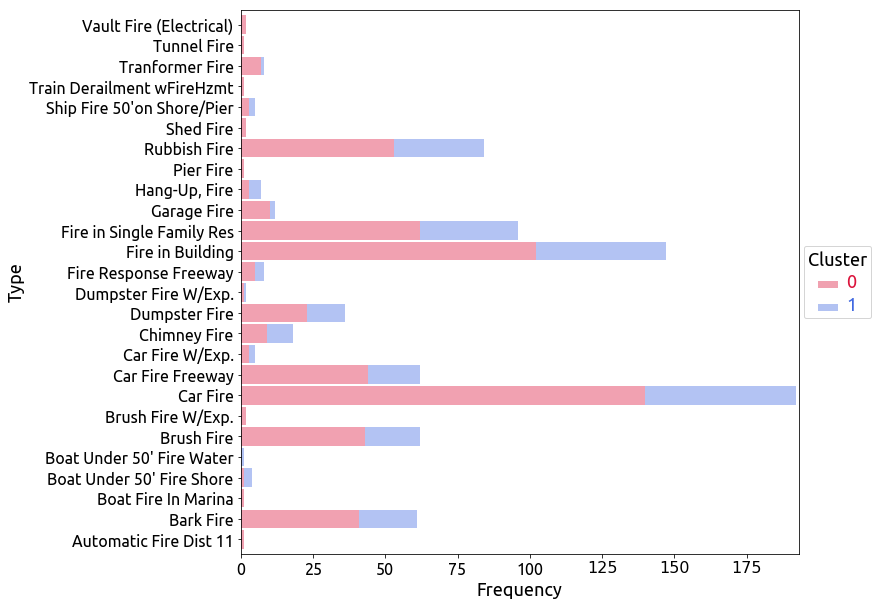

In [18]:
ax = pd.crosstab(df2_big_types.Type,df2_big_types.pca_2D).plot.barh(stacked=True,color=['crimson','royalblue', 'forestgreen', 'darkorange'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','2','3'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'forestgreen')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'darkorange')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Type', fontsize=18, fontname='Ubuntu')
#ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Type of calls for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
ax.set_xlim([0, 3080])
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(10, 1)
plt.show()


ax = pd.crosstab(df2_small_types.Type,df2_small_types.pca_2D).plot.barh(stacked=True,color=['crimson','royalblue'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Type', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


#ax.set_title("Type of calls for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
ax.set_xlim([0, 193])
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(10, 10)
plt.show()

## 3D PCA Clustering

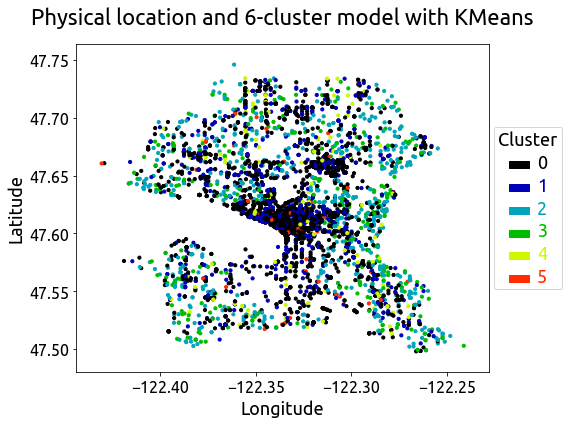

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

n_colors = len(df2['pca_3D'].unique())

colors = cm.nipy_spectral(df2['pca_3D'].values.astype(float) / n_colors)

colors_0 = cm.nipy_spectral(np.linspace(0, n_colors-1, num=n_colors).astype(float) / n_colors)
handles_0 = [mpatches.Patch(color=colors_0[i], label=str(i)) for i in range(n_colors)] 

ax.scatter(df2['Longitude'],df2['Latitude'],c=colors,alpha=1, s=10)

legend = plt.legend(handles=handles_0, title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))
for i in range(n_colors):
    plt.setp(ax.get_legend().get_texts()[i], fontsize='18', fontname='Ubuntu', color = colors_0[i])
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')


ax.set_title("Physical location and "+str(n_colors)+"-cluster model with KMeans", fontsize=22, fontname='Ubuntu', pad= 20)
ax.set_xlabel("Longitude", fontsize=18, fontname='Ubuntu')
ax.set_ylabel("Latitude", fontsize=18, fontname='Ubuntu')
ax.tick_params(labelsize=16)
ax.grid(False)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

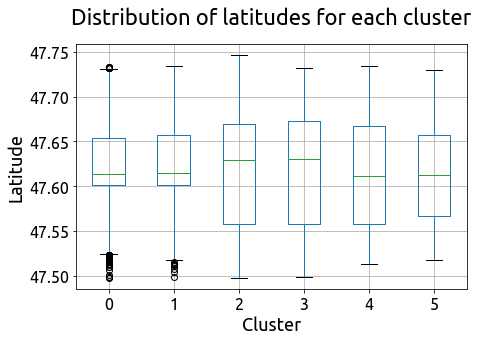

In [20]:
ax = df2.pivot(columns='pca_3D', values='Latitude').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Latitude', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Distribution of latitudes for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4.5)
plt.show()

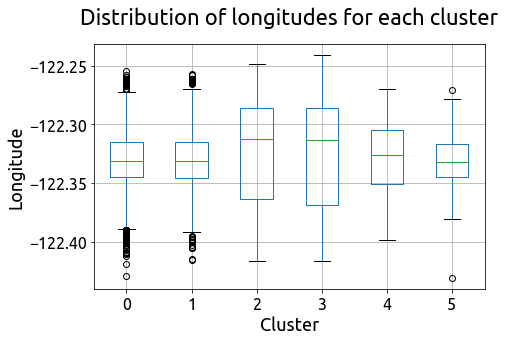

In [21]:
ax = df2.pivot(columns='pca_3D', values='Longitude').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Longitude', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Distribution of longitudes for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4.5)
plt.show()

In [22]:
pd.crosstab(df2.pca_3D, df2.Off_Day)

Off_Day,False,True
pca_3D,,
0,2511,0
1,0,1180
2,616,0
3,0,308
4,140,0
5,0,52


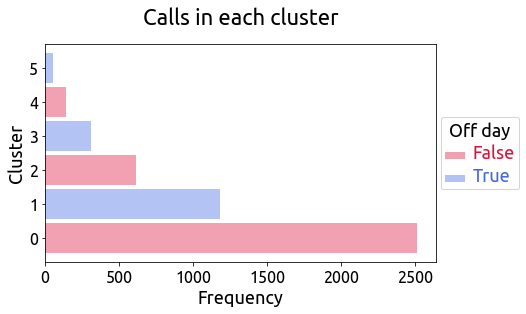

In [23]:
ax = pd.crosstab(df2.pca_3D, df2.Off_Day).plot.barh(stacked=True,color=['crimson','royalblue'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['False','True'], title="Off day", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Calls in each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4)
plt.show()

In [24]:
2090 + 972

3062

In [25]:
print(pd.crosstab(df2_big_types.Type,df2_big_types.pca_3D))
print('')
print('')
print(pd.crosstab(df2_small_types.Type,df2_small_types.pca_3D))

pca_3D                        0    1    2    3
Type                                          
Auto Fire Alarm            2090  972    0    0
Automatic Fire Alarm Resd     0    0  616  308


pca_3D                        0   1    4   5
Type                                        
Automatic Fire Dist 11        1   0    0   0
Bark Fire                    41  20    0   0
Boat Fire In Marina           1   0    0   0
Boat Under 50' Fire Shore     1   3    0   0
Boat Under 50' Fire Water     0   1    0   0
Brush Fire                   43  19    0   0
Brush Fire W/Exp.             2   0    0   0
Car Fire                      0   0  140  52
Car Fire Freeway             44  18    0   0
Car Fire W/Exp.               3   2    0   0
Chimney Fire                  9   9    0   0
Dumpster Fire                23  13    0   0
Dumpster Fire W/Exp.          1   1    0   0
Fire Response Freeway         5   3    0   0
Fire in Building            102  45    0   0
Fire in Single Family Res    62  34    0   0


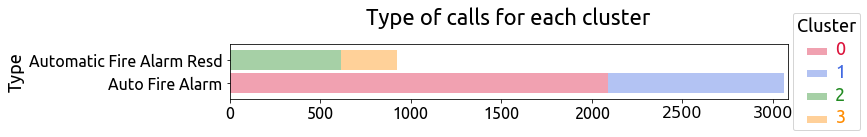

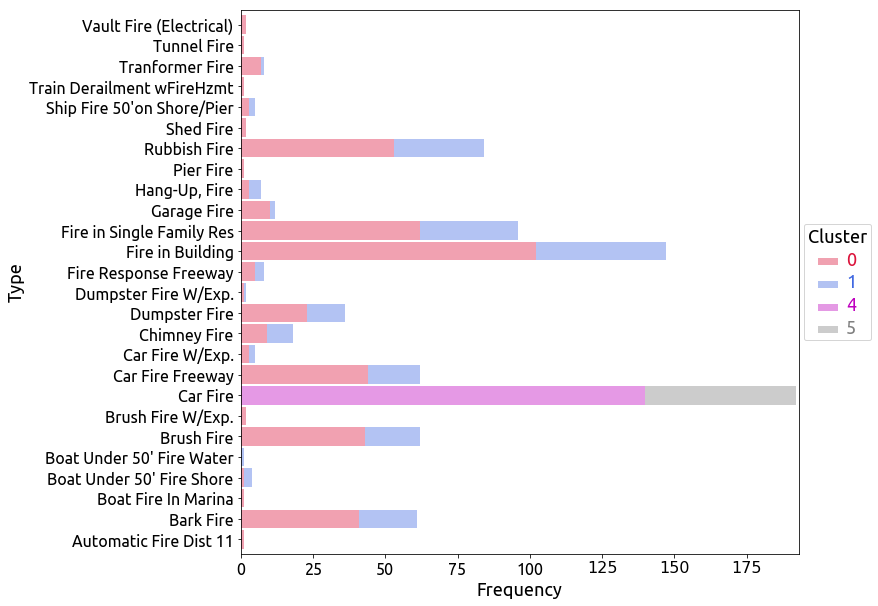

In [26]:
ax = pd.crosstab(df2_big_types.Type,df2_big_types.pca_3D).plot.barh(stacked=True,color=['crimson','royalblue', 'forestgreen', 'darkorange'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','2','3'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'forestgreen')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'darkorange')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Type', fontsize=18, fontname='Ubuntu')
#ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Type of calls for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
ax.set_xlim([0, 3080])
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(10, 1)
plt.show()


ax = pd.crosstab(df2_small_types.Type,df2_small_types.pca_3D).plot.barh(stacked=True,color=['crimson','royalblue','m','gray'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','4','5'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'm')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'gray')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Type', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


#ax.set_title("Type of calls for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
ax.set_xlim([0, 193])
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(10, 10)
plt.show()

## Location Clustering

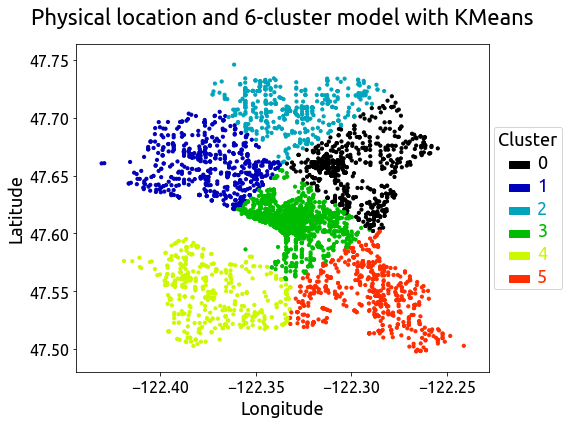

In [27]:
fig, ax = plt.subplots(figsize=(8,6))

n_colors = len(df2['k_location'].unique())

colors = cm.nipy_spectral(df2['k_location'].values.astype(float) / n_colors)

colors_0 = cm.nipy_spectral(np.linspace(0, n_colors-1, num=n_colors).astype(float) / n_colors)
handles_0 = [mpatches.Patch(color=colors_0[i], label=str(i)) for i in range(n_colors)] 

ax.scatter(df2['Longitude'],df2['Latitude'],c=colors,alpha=1, s=10)

legend = plt.legend(handles=handles_0, title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))
for i in range(n_colors):
    plt.setp(ax.get_legend().get_texts()[i], fontsize='18', fontname='Ubuntu', color = colors_0[i])
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')


ax.set_title("Physical location and "+str(n_colors)+"-cluster model with KMeans", fontsize=22, fontname='Ubuntu', pad= 20)
ax.set_xlabel("Longitude", fontsize=18, fontname='Ubuntu')
ax.set_ylabel("Latitude", fontsize=18, fontname='Ubuntu')
ax.tick_params(labelsize=16)
ax.grid(False)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

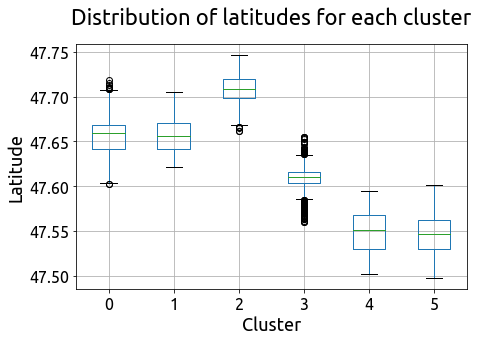

In [28]:
ax = df2.pivot(columns='k_location', values='Latitude').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Latitude', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Distribution of latitudes for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4.5)
plt.show()

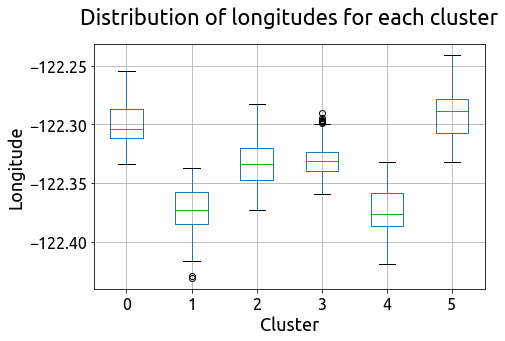

In [29]:
ax = df2.pivot(columns='k_location', values='Longitude').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Longitude', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Distribution of longitudes for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4.5)
plt.show()

In [30]:
pd.crosstab(df2.k_location, df2.Off_Day)

Off_Day,False,True
k_location,,
0,544,234
1,411,207
2,320,175
3,1290,586
4,311,152
5,391,186


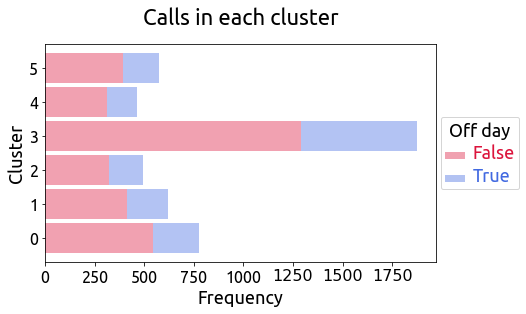

In [31]:
ax = pd.crosstab(df2.k_location, df2.Off_Day).plot.barh(stacked=True,color=['crimson','royalblue'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['False','True'], title="Off day", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Calls in each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4)
plt.show()

In [32]:
print(pd.crosstab(df2_big_types.Type,df2_big_types.k_location))
print('')
print('')
print(pd.crosstab(df2_small_types.Type,df2_small_types.k_location))

k_location                   0    1    2     3    4    5
Type                                                    
Auto Fire Alarm            421  337  291  1540  219  254
Automatic Fire Alarm Resd  259  164   94    63  151  193


k_location                   0   1   2   3   4   5
Type                                              
Automatic Fire Dist 11       0   0   0   1   0   0
Bark Fire                    8   9  10  23   5   6
Boat Fire In Marina          0   0   0   0   0   1
Boat Under 50' Fire Shore    0   4   0   0   0   0
Boat Under 50' Fire Water    0   1   0   0   0   0
Brush Fire                  10  13   6   9   7  17
Brush Fire W/Exp.            0   0   1   0   0   1
Car Fire                    21  17  34  60  24  36
Car Fire Freeway             5   1  13  30   4   9
Car Fire W/Exp.              0   2   1   1   0   1
Chimney Fire                 3   4   2   2   4   3
Dumpster Fire                6   6   4  15   3   2
Dumpster Fire W/Exp.         0   0   0   1   1   0
Fire 

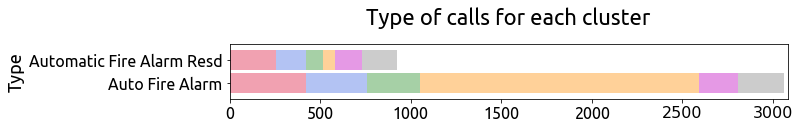

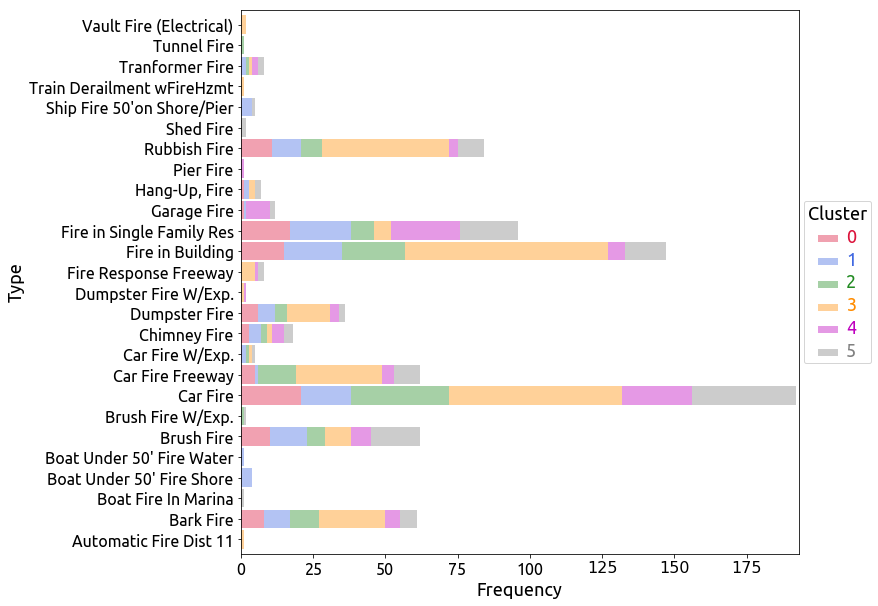

In [33]:
ax = pd.crosstab(df2_big_types.Type,df2_big_types.k_location).plot.barh(stacked=True,color=['crimson','royalblue', 'forestgreen', 'darkorange','m','gray'], alpha=0.4, width=0.9)

#legend = ax.legend(labels=['0','1','2','3','4','5'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

#plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
#plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
#plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'forestgreen')
#plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'darkorange')
#plt.setp(ax.get_legend().get_texts()[4], fontsize='18', fontname='Ubuntu', color = 'm')
#plt.setp(ax.get_legend().get_texts()[5], fontsize='18', fontname='Ubuntu', color = 'gray')
#plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')
ax.legend_.remove()


ax.set_ylabel('Type', fontsize=18, fontname='Ubuntu')
#ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Type of calls for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
ax.set_xlim([0, 3080])
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(10, 1)
plt.show()


ax = pd.crosstab(df2_small_types.Type,df2_small_types.k_location).plot.barh(stacked=True,color=['crimson','royalblue', 'forestgreen', 'darkorange','m','gray'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','2','3','4','5'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'forestgreen')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'darkorange')
plt.setp(ax.get_legend().get_texts()[4], fontsize='18', fontname='Ubuntu', color = 'm')
plt.setp(ax.get_legend().get_texts()[5], fontsize='18', fontname='Ubuntu', color = 'gray')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Type', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


#ax.set_title("Type of calls for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
ax.set_xlim([0, 193])
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(10, 10)
plt.show()

## Complete Data Set Clustering without PCA

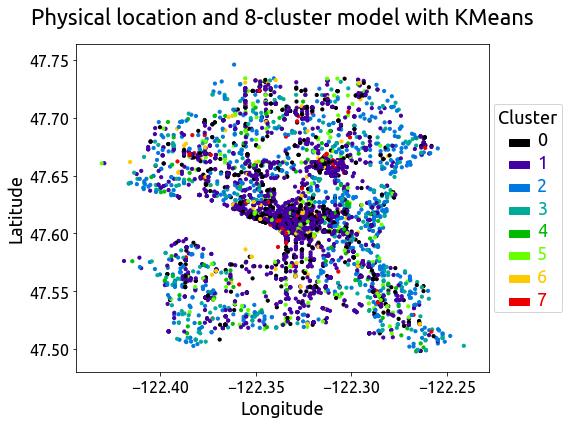

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

n_colors = len(df2['k_complete'].unique())

colors = cm.nipy_spectral(df2['k_complete'].values.astype(float) / n_colors)

colors_0 = cm.nipy_spectral(np.linspace(0, n_colors-1, num=n_colors).astype(float) / n_colors)
handles_0 = [mpatches.Patch(color=colors_0[i], label=str(i)) for i in range(n_colors)] 

ax.scatter(df2['Longitude'],df2['Latitude'],c=colors,alpha=1, s=10)

legend = plt.legend(handles=handles_0, title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))
for i in range(n_colors):
    plt.setp(ax.get_legend().get_texts()[i], fontsize='18', fontname='Ubuntu', color = colors_0[i])
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')


ax.set_title("Physical location and "+str(n_colors)+"-cluster model with KMeans", fontsize=22, fontname='Ubuntu', pad= 20)
ax.set_xlabel("Longitude", fontsize=18, fontname='Ubuntu')
ax.set_ylabel("Latitude", fontsize=18, fontname='Ubuntu')
ax.tick_params(labelsize=16)
ax.grid(False)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

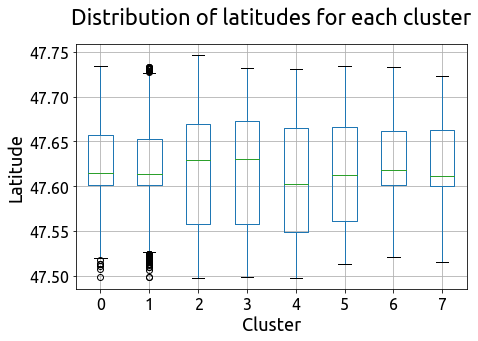

In [35]:
ax = df2.pivot(columns='k_complete', values='Latitude').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Latitude', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Distribution of latitudes for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4.5)
plt.show()

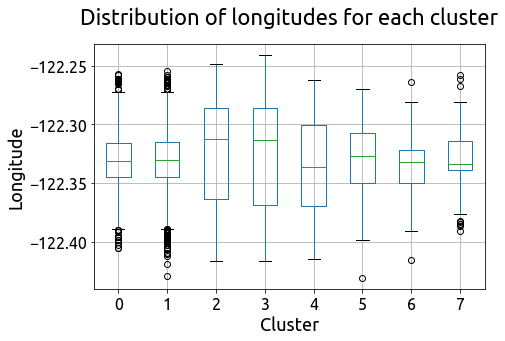

In [36]:
ax = df2.pivot(columns='k_complete', values='Longitude').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Longitude', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Distribution of longitudes for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4.5)
plt.show()

In [37]:
pd.crosstab(df2.k_complete, df2.Off_Day)

Off_Day,False,True
k_complete,,
0,0,1070
1,2294,0
2,616,0
3,0,308
4,62,34
5,140,52
6,102,45
7,53,31


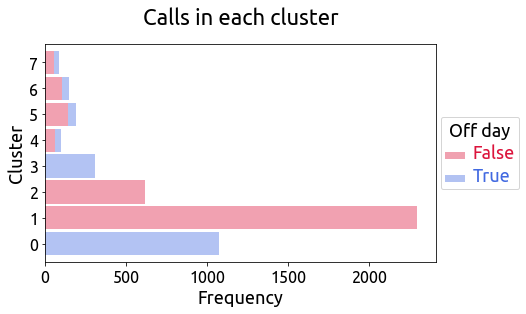

In [38]:
ax = pd.crosstab(df2.k_complete, df2.Off_Day).plot.barh(stacked=True,color=['crimson','royalblue'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['False','True'], title="Off day", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Calls in each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(7, 4)
plt.show()

In [39]:
print(pd.crosstab(df2_big_types.Type,df2_big_types.k_complete))
print('')
print('')
print(pd.crosstab(df2_small_types.Type,df2_small_types.k_complete))

k_complete                   0     1    2    3
Type                                          
Auto Fire Alarm            972  2090    0    0
Automatic Fire Alarm Resd    0     0  616  308


k_complete                   0   1   4    5    6   7
Type                                                
Automatic Fire Dist 11       0   1   0    0    0   0
Bark Fire                   20  41   0    0    0   0
Boat Fire In Marina          0   1   0    0    0   0
Boat Under 50' Fire Shore    3   1   0    0    0   0
Boat Under 50' Fire Water    1   0   0    0    0   0
Brush Fire                  19  43   0    0    0   0
Brush Fire W/Exp.            0   2   0    0    0   0
Car Fire                     0   0   0  192    0   0
Car Fire Freeway            18  44   0    0    0   0
Car Fire W/Exp.              2   3   0    0    0   0
Chimney Fire                 9   9   0    0    0   0
Dumpster Fire               13  23   0    0    0   0
Dumpster Fire W/Exp.         1   1   0    0    0   0
Fire Response F

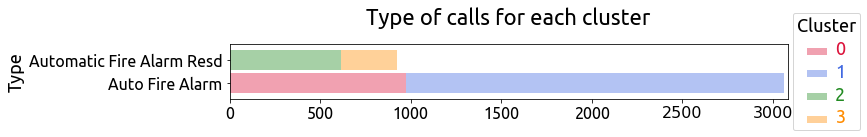

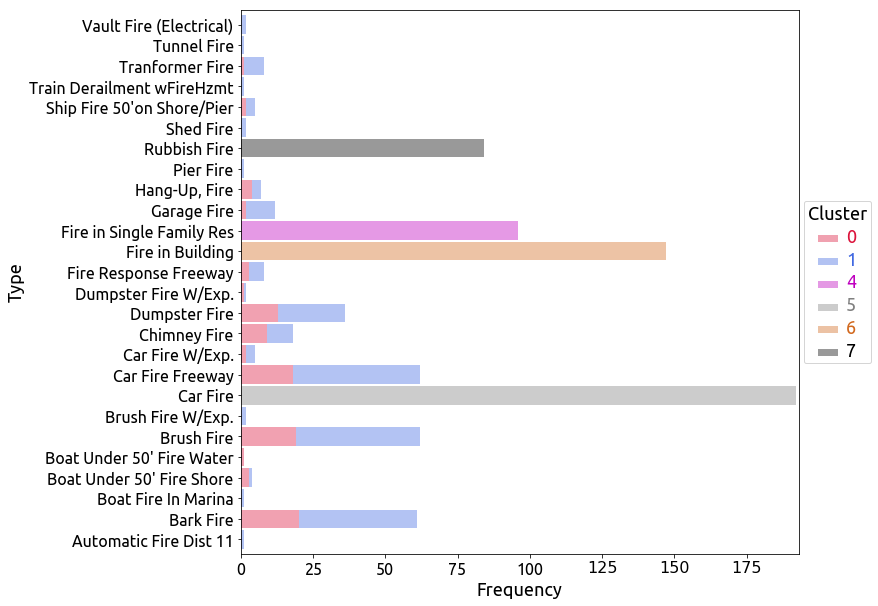

In [41]:
ax = pd.crosstab(df2_big_types.Type,df2_big_types.k_complete).plot.barh(stacked=True,color=['crimson','royalblue', 'forestgreen', 'darkorange'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','2','3'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'forestgreen')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'darkorange')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')



ax.set_ylabel('Type', fontsize=18, fontname='Ubuntu')
#ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Type of calls for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
ax.set_xlim([0, 3080])
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(10, 1)
plt.show()


ax = pd.crosstab(df2_small_types.Type,df2_small_types.k_complete).plot.barh(stacked=True,color=['crimson','royalblue','m','gray','chocolate','black'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','4','5','6','7'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'm')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'gray')
plt.setp(ax.get_legend().get_texts()[4], fontsize='18', fontname='Ubuntu', color = 'chocolate')
plt.setp(ax.get_legend().get_texts()[5], fontsize='18', fontname='Ubuntu', color = 'black')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Type', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


#ax.set_title("Type of calls for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
ax.set_xlim([0, 193])
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
fig = np.asarray(ax).reshape(-1)[0].get_figure()
fig.set_size_inches(10, 10)
plt.show()